# 前言

在国内外股票市场中，长期存在着低波动异象(Low-Volatility Anomaly)。传统资本资产定价模型(CAPM)和套利定价理论(APT)告诉我们，资产的预期收益与其风险正相关，理论上高风险股票相对低风险股票应该具有更高收益回报。但越来越多的经验证据表明，低波动股票收益表现往往优于高波动股票，股票收益与波动之间存在着负相关性。

`波动类因子在A股市场具有负向选股能力：波动程度较低的股票，未来有相对较好的收益表现`。由于本报告对因子微观结构的讨论，将涉及到对因子的“切割”，综合考虑因子的可切割性以及因子值对样本数量的敏感性，本文我们统一`选取振幅因子作为波动类因子的代理变量。`

振幅因子在稳定性上的不足，引发了我们对振幅因子隐藏结构的进一步探索。我们知道，`振幅因子衡量了股票在过去一段时间内振幅的平均水平，但它无法对振幅分布的差异性进行进一步分析和刻画`。我们不禁思考：不同维度下的振幅分布差异是否蕴含有不同的信息？为了进一步分析振幅因子的信息结构，我们这里引入价格维度。这一步骤的主要动机是：我们知道，振幅因子可以衡量资金多空博弈的激烈程度，而不同价格位置的资金多空博弈情况往往蕴含不同的意义。

为了形象直观的理解，我们设想以下情景：假设股票S过去20个交易日的收盘 价构成集合[10.01,10.02，…，10.19,10.20]，图3给出了股票S在不同价格处日度振 幅的两种分布情形：左图为高价格处振幅较高情形，右图为低价格处振幅较高情形。 图中纵轴为价格分布，蓝柱长度代表不同价格处的振幅大小，这里假设左右两图中 振幅均值相同。可以发现，传统振幅因子在两种不同振幅分布下具有相同的因子值。显而易见，不同价格区间的振幅分布差异并没有被有效挖掘与刻画。

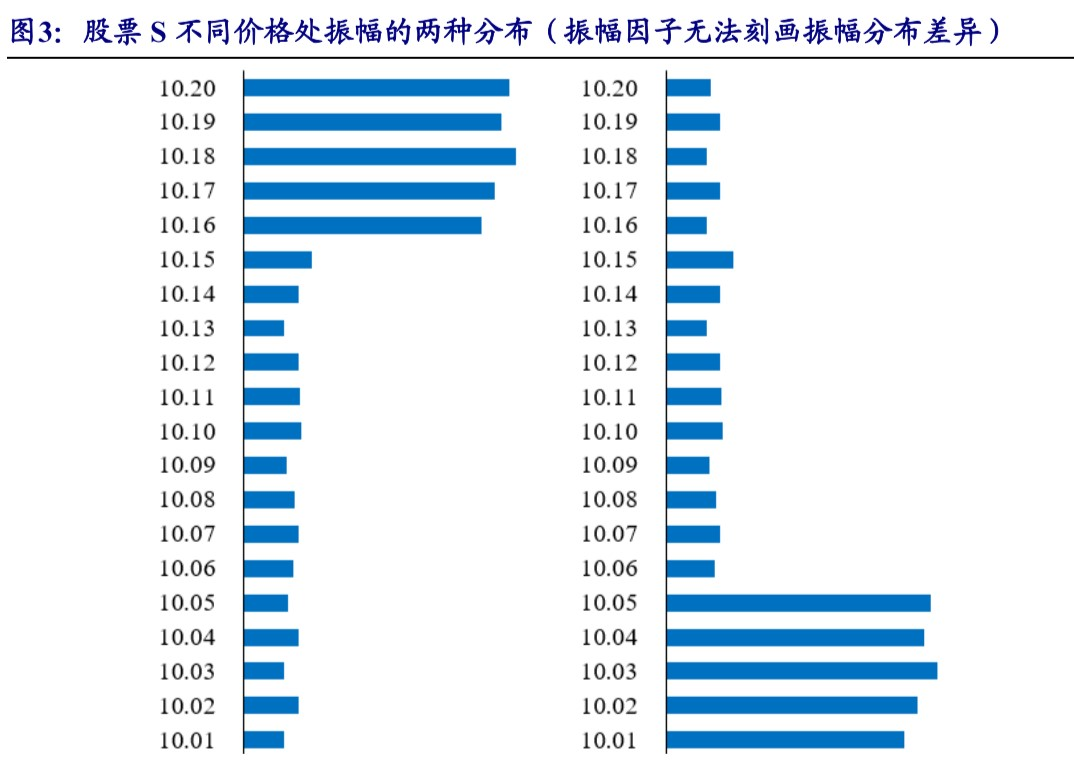

根据上文的讨论，我们预期在不同价格位置，振幅分布所蕴含的信息会存在结构性差异。接下来我们将从价格维度对振幅因子进行不同切割，并提出了对振幅因子的重要改进。

In [94]:
# 引入库
import sys
sys.path.append('../../..')

from BuildPeriodDate import (GetTradePeriod,tdaysoffset)

import numpy as np
import pandas as pd
import empyrical as ep
import alphalens as al
import scipy.stats as st
import alphalens.performance as perf
from alphalens.utils import print_table

from jqdata import *
from jqfactor import (Factor,calc_factors)

import itertools
from typing import (Tuple,List,Dict,Union,Callable)
from functools import reduce
from tqdm import tqdm_notebook
from dateutil.parser import parse


import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['font.family']='serif' # pd.plot中文
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

**工具函数准备**

**1.股票池过滤**

- 过滤上市小于60日的股票；
- 过滤停牌大于20日的股票;
- 过滤ST,\*ST股票

In [2]:
# 获取股票池
def get_stockpool(symbol: str, watch_date: str) -> list:
    '''获取股票池'''

    if symbol == 'A':
        stockList = get_index_stocks('000001.XSHG', date=watch_date) + get_index_stocks(
            '399107.XSHE', date=watch_date)
    else:
        stockList = get_index_stocks(symbol, date=watch_date)
        
    stockList = del_st_stock(stockList, watch_date)  # 过滤ST
    stockList = del_iponday(stockList, watch_date)   # 过滤上市不足60日
    stockList = del_pause(stockList,watch_date)      # 过滤当日停牌的股票
    return stockList

def del_st_stock(securities: list, watch_date: str) -> list:
    '''过滤ST股票'''

    info_ser = get_extras('is_st', securities,
                          end_date=watch_date, df=True, count=1).iloc[0]

    return info_ser[info_ser == False].dropna().index.tolist()

def del_iponday(securities: list, watch_date: str, N: int = 60) -> list:
    '''返回上市大于N日的股票'''
    dic = {x: get_security_info(x, date=watch_date).start_date for x in securities if get_security_info(
        x, date=watch_date) != None}
    return [code for code, start_date in dic.items() if (parse(watch_date).date() - start_date).days > N]

def del_pause(securities:list,watch_date:str,N:int=10)->list:
    
    '''
    过滤停牌股,默认为过滤当日停牌的
    '''
    
    paused = get_price(securities,end_date=watch_date,count=N,fields='paused',panel=False)
    
    if N == 1:
        return paused.query('paused != 1')['code'].values.tolist()
    else:
        
        paused_num = paused.groupby('code')['paused'].sum()
        return paused_num[paused_num < N].index.values.tolist()

**2.获取因子**

In [3]:
# 因子计算
def prepare_data(symbol: str, start: str, end: str, last_date: str, factor: Callable, grid_func_params: Dict) -> pd.DataFrame:
    '''
    symbol:股票池所属成份，A为全市场
    start,end:回测区间 频率为月度
    last_date:计算next_returns的最后一日的日期
    factor:构建的因子
    '''
    periods = GetTradePeriod(start, end, 'ME')  # 月度_周期获取
    periods = periods + [last_date]
    factor_dic = {}

    for tradeDate, nextDate in tqdm_notebook(zip(periods[:-1], periods[1:]), total=len(periods)-1, desc='因子计算'):

        # 股票池
        stock_pool = get_stockpool(symbol, tradeDate.strftime('%Y-%m-%d'))

        # 因子获取

        f = factor(stock_pool, tradeDate, 20)
        
        # 获取数据 这里仅需获取一次就能使用该数据进行N此不同参数运算
        f.get_data() 
        # 可以使用不同参数进行计算
        factor_frame = grid_func_params['func'](
            f, **grid_func_params['params'])

        # 计算下期收益率
        close = get_price(stock_pool, end_date=tradeDate, count=1,
                          fields='close', panel=False).set_index('code')

        next_close = get_price(stock_pool, end_date=nextDate,
                               count=1, fields='close', panel=False).set_index('code')

        next_returns = next_close['close'] / close['close'] - 1
        next_returns.name = 'next_ret'

        # 合并
        tmp = pd.concat((factor_frame, next_returns), axis=1)
        factor_dic[tradeDate] = tmp  # 放入容器

    factor_df = pd.concat(factor_dic)

    factor_df.index.names = ['date', 'code']

    return factor_df


def dict2frame(dic: dict) -> pd.DataFrame:
    '''将data的dict格式转为df'''

    df = pd.concat((df.iloc[-1] for df in dic.values()), axis=1)
    df.columns = list(dic.keys())

    return df

**3.因子构建**

In [4]:
# 振幅因子
class AF_factor(object):

    '''
    lamb为切分变量
    group为高低分组high,low两个参数
    '''

    def __init__(self, securities: Union[str, list], watch_date: str, N: int) -> None:

        self.securities = securities

        self.watch_date = watch_date

        self._N = N

        self.max_window = N + 2

    def get_data(self):
        '''数据获取'''

        data = get_price(self.securities,
                         end_date=self.watch_date,
                         count=self.max_window,
                         fields=['close', 'high', 'low', 'paused'], panel=False)

        self.data = data.pivot(index='time', columns='code')

    def calc(self, lamb: float, group: str) -> pd.Series:
        '''因子计算'''
        self.lamb = round(lamb,2)
        self.group = group

        af_df = self._calc_af()
        af_df = af_df.iloc[-self._N:]

        cond1 = self._q_split()
        cond1 = cond1.iloc[-self._N:]

        cond2 = self._get_paused()
        cond2 = cond2.iloc[-self._N:]

        cond = cond1 * cond2

        ser = (af_df * cond).mean()
        ser.name = self.name
        return ser

    def _q_split(self) -> pd.DataFrame:
        '''分割'''
        close = self.data['close']
        
        cond = close.rank(pct=True) >= self.lamb
        
        if self.group == 'high':

            return cond

        elif self.group == 'low':

            return ~cond

        else:
            raise ValueError('group参数仅能为high,low.')

    def _calc_af(self) -> pd.DataFrame:
        '''计算振幅'''
        return self.data['high'] / self.data['low'] - 1

    def _get_paused(self) -> pd.DataFrame:
        '''一字跌停后一日标记为False'''
        close_df = self.data['close']
        high_df = self.data['high']
        low_df = self.data['low']
        paused = self.data['paused'] # 停牌
      
        # 跌停
        cond1 = (close_df / close_df.shift(1) - 1) < -0.09
        # 一字
        cond2 = (high_df == low_df)

        res = (cond1 & cond2)
        res = (paused + res).astype(bool)
        
        return (~res).shift(1)

    @property
    def name(self) -> str:

        return f'AF_{round(self.lamb,2)}_{self.group}'

# 因子参数构造
def grid_factor(factor: Callable, lamb: Union[float, list], group: Union[str, list]) -> pd.DataFrame:

    if isinstance(lamb, (float, int)):
        lamb = [lamb]

    if isinstance(group, str):

        group = [group]

    df_list = []
    for l, g in itertools.product(lamb, group):

        df_list.append(factor.calc(l, g))

    return pd.concat(df_list, axis=1)

**4.组合收益风险指标**

In [42]:
# 风险指标
def risk_indicator_tear(returns:pd.DataFrame,period:str='monthly')->pd.DataFrame:
    
    tear = pd.DataFrame()
    tear['annual_return'] = ep.annual_return(returns,period)
    tear['annual_volatility'] = returns.apply(lambda x:ep.annual_volatility(x,period))
    tear['max_drawdown'] = returns.apply(lambda x:ep.max_drawdown(x))
    
    return tear

# 振幅因子的切割：高价振幅因子具有更强的负向选股能力

为了衡量不同价格下的振幅分布信息差异，我们给出了价格维度下的振幅因子 切割方案，具体切割步骤如下：

|步骤|描述|
|--|--|
|步骤1|对选定股票S,回溯取其最近N个交易日(N=20)的数据;|
|步骤2|计算股票S每日的**振幅**(最高价/最低价-1);|
|步骤3|选择收盘价较高的λ（比如 40%）有效交易日，计算振幅均值得到高价振幅 因子V_high(λ)|
|步骤4|选择收盘价较低的λ（比如 40%）有效交易日，计算振幅均值得到低价振幅 因子V_low(λ)|


需要说明的是，有效交易日是指剔除`停牌`和`一字涨跌停后`的交易日。若股票S在 最近20个交易日内，有效交易日天数小于10日，则股票S当日因子值设为空值。同时为了更加精细的衡量不同价格位置处的振幅因子差异，我们选取不同的λ取值来构造高价振幅因子和低价振幅因子。可以知道，当λ=100%时，高价振幅因子V_high和低价振幅因子V_low 即为传统振幅因子。

In [5]:
# 因子获取
factor_df = prepare_data('A','2010-01-01','2020-12-31','2021-01-31',
             AF_factor,{'func':grid_factor,'params':{'lamb':np.arange(0.2,1.1,0.1),'group':['high','low']}})

从不同λ值的因子IC均值和 ICIR上看：

1. 高价振幅因子V_high：随着切割比例λ由20%至100%过程中，高价振幅因子的IC均值的绝对值和ICIR绝对值逐渐增大，表明高价振幅因子的负向选股能力逐渐增强。当λ为80%时，因子IC均值为-0.093，ICIR为-0.75,随着λ增大正向选股能力突然增强。
2. 低价振幅因子 V_low：随着切割比例λ由100%逐渐减小至20%过程中，低价振幅因子的IC均值的绝对值和ICIR绝对值逐渐减小至0附近，表明低价振幅因子的选股能力逐渐减弱。

从回测结果我们可以发现：高价振幅和低价振幅所蕴含的信息存在结构性差异，价格较高处振幅具有 更强的负向选股能力。相比于传统振幅因子，高价振幅因子V_high 具有更加优异的选股效果。

In [6]:
# 计算ic
def src_ic(df:pd.DataFrame)->pd.DataFrame:
    
    '''计算IC'''
    
    f = [col for col in df.columns if col != 'next_ret']
    
    _ic = df[f].apply(lambda x:st.spearmanr(x,df['next_ret'])[0])
    
    return _ic

In [7]:
# IC计算
ic_df = factor_df.fillna(0).groupby(level='date').apply(src_ic)

high_ic = ic_df.filter(regex='high')
low_ic = ic_df.filter(regex='low')

high_ic.columns = [f'%.2f%%' % (float(col[1]) * 100)
                       for col in high_ic.columns.str.split('_')]
low_ic.columns = [f'%.2f%%' % (float(col[1]) * 100)
                      for col in low_ic.columns.str.split('_')]

# 获取high组的mean ic
h_mean = high_ic.mean()
h_std = high_ic.std()
h_icir = h_mean / h_std

# 获取low组的mean ic
l_mean = low_ic.mean()
l_std = low_ic.std()
l_icir = l_mean / l_std

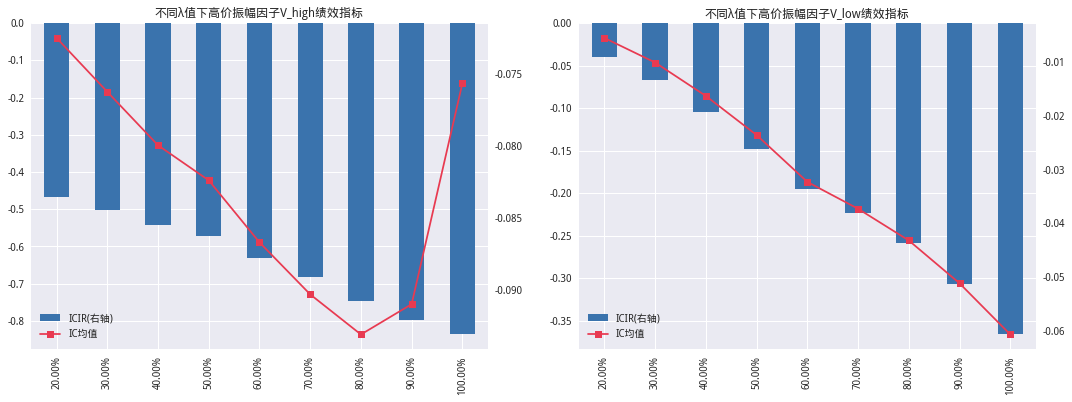

In [8]:
# 画图
mpl.rcParams['font.family'] = 'serif'
fig, icir_axes = plt.subplots(1, 2, figsize=(18, 6))

icir_axes[0].set_title('不同λ值下高价振幅因子V_high绩效指标')
h_icir.plot.bar(ax=icir_axes[0], label='ICIR(右轴)', color='#3A73AD')

icir_axes_tx1 = icir_axes[0].twinx()
h_mean.plot(ax=icir_axes_tx1, label='IC均值',marker='s', color='#E83A51')
plt.grid(False)

h1, l1 = icir_axes[0].get_legend_handles_labels()
h2, l2 = icir_axes_tx1.get_legend_handles_labels()
icir_axes[0].legend(h1+h2, l1+l2)


icir_axes[1].set_title('不同λ值下高价振幅因子V_low绩效指标')
l_icir.plot.bar(ax=icir_axes[1], label='ICIR(右轴)', color='#3A73AD')

icir_axes_tx2 = icir_axes[1].twinx()
l_mean.plot(ax=icir_axes_tx2, label='IC均值',marker='s', color='#E83A51')
plt.grid(False)

h1, l1 = icir_axes[1].get_legend_handles_labels()
h2, l2 = icir_axes_tx2.get_legend_handles_labels()
icir_axes[1].legend(h1+h2, l1+l2)
plt.grid(False)

虽然高价振幅因子具有较优的负向选股能力，但多空对冲净值波动性较高。以λ取值 20%为例，高价振幅因子V_high（λ=20%）多空对冲年化收益较高（9.28%），但年化波动率（14.81%）和最大回撤（18.48%）也相对较高。同时观察高价振幅因子的5分组收益可以发现，不同分组收益的非单调性相较于传统振幅因子有所改善，但依然不单调。

In [9]:
# 获取分组
def add_group(ser: pd.Series, N: int = 5) -> pd.Series:

    name = ['G%s' % x for x in range(1, N+1)]
    return pd.qcut(ser, N, labels=name,duplicates='drop')

# 获取分组收益率
def get_algorithm_ret(factor_df: pd.DataFrame, col: str) -> pd.DataFrame:

    group_ser = factor_df.groupby(level='date')[col].apply(add_group)
    group_df = pd.concat((factor_df['next_ret'], group_ser), axis=1)

    group_ret = pd.pivot_table(group_df.reset_index(
    ), index='date', columns=col, values='next_ret')
    group_ret.columns = list(map(str, group_ret.columns))
    group_ret['excess_ret'] = group_ret['G1'] - group_ret['G5']

    return group_ret

# 获取多空收益
def get_excess_ret(factor_df: pd.DataFrame, col: list) -> pd.DataFrame:

    if isinstance(col, (str, float, int)):
        col = [col]

    df = pd.concat((get_algorithm_ret(factor_df, x)[
                   'excess_ret'] for x in col), axis=1)
    df.columns = col
    return df

In [53]:
# 获取高低分组
high_factor = factor_df.filter(regex='high').copy()
low_factor = factor_df.filter(regex='low').copy()

high_factor.columns = [f'%.2f%%' % (float(col[1]) * 100)
                       for col in high_factor.columns.str.split('_')]

low_factor.columns = [f'%.2f%%' % (float(col[1]) * 100)
                       for col in low_factor.columns.str.split('_')]

high_factor['next_ret'] = factor_df['next_ret']

# 计算多空收益
excess_ret = get_excess_ret(high_factor, list(
    map(lambda x: '%.2f%%' % x, range(20, 100, 10))))

excess_cum = ep.cum_returns(excess_ret).add(1)

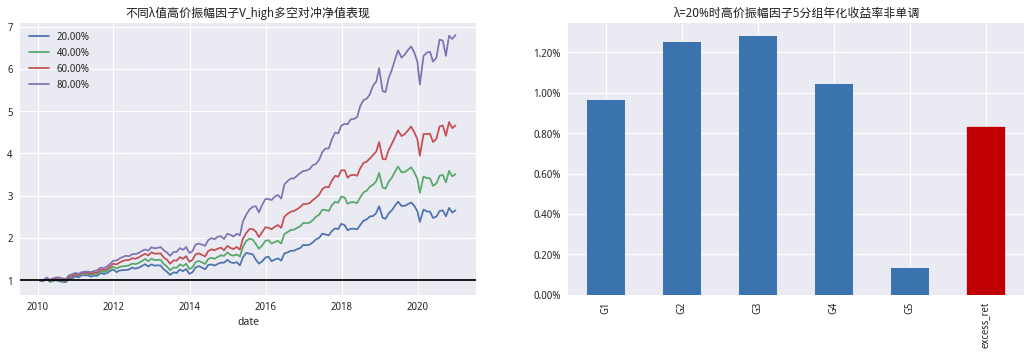

In [54]:
# 画图
mpl.rcParams['font.family'] = 'serif'
fig, excess_plot = plt.subplots(1, 2)

def set_color_condition(objs, idx, color):

    objs[idx].set_color(color)
    
# 画净值
excess_cum[['20.00%', '40.00%', '60.00%', '80.00%']].plot(
    figsize=(18, 5), title='不同λ值高价振幅因子V_high多空对冲净值表现', ax=excess_plot[0])
excess_plot[0].axhline(1, color='black')

# 画分组平均收益率
lamb_2 = get_algorithm_ret(high_factor, '20.00%')
lamb_2.mean().plot.bar(title='λ=20%时高价振幅因子5分组年化收益率非单调',
                       ax=excess_plot[1], color='#3A73AD')

yaxis_format = mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x*100))
excess_plot[1].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(yaxis_format))
bar_ct = excess_plot[1].containers[0]
idx = lamb_2.mean().index.get_loc('excess_ret')
set_color_condition(bar_ct, idx, '#C00000')


In [56]:
# 各组合多空对冲收益情况
risk_indicator_tear(excess_ret).T.style.format('{:.2%}')

,20.00%,30.00%,40.00%,50.00%,60.00%,70.00%,80.00%,90.00%
annual_return,9.28%,10.24%,12.10%,13.32%,15.02%,17.21%,19.03%,19.63%
annual_volatility,14.81%,14.65%,14.35%,14.09%,13.83%,13.54%,12.95%,11.97%
max_drawdown,-18.48%,-18.17%,-18.12%,-17.76%,-16.37%,-14.34%,-13.87%,-12.59%


# 理想振幅因子的选股能力要显著优于高价振幅因子

为了提升高价振幅因子V_high 的选股稳定性，我们考虑在横截面上对高价振幅 因子进行标准化处理。这里标准化的做法是：在同一切割比例λ下，我们将高价振幅
因子 V_high 与低价振幅因子 V_low 作差，构造得到理想振幅因子 V，表达式如下：

$$V(\lambda) = V_high(\lambda) - V_low(\lambda)$$

完成理想振幅因子的构造后，我们首先对不同切割比例下高价振幅因子和低价振幅因子的IC均值结构进行对比。从图下可以看出：随着λ值的逐渐减小，V_high 与V_low 因子IC均值的差距逐渐增加，图形上的效果则是呈现出“>”形状。因此我们预期：随着切割比例λ值的逐渐减小，对应的理想振幅因子V(λ)的选股能力会呈现出逐渐增强趋势。

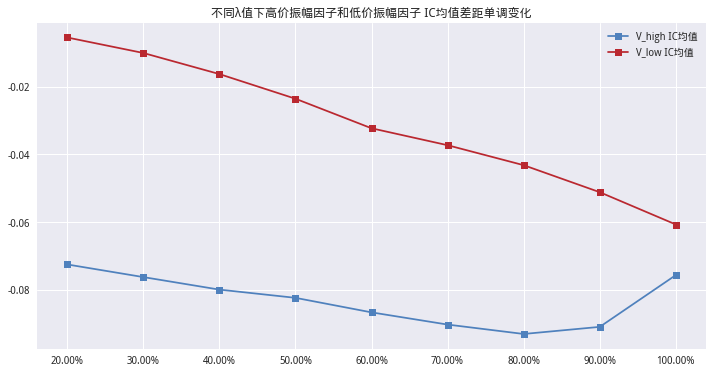

In [12]:
# 画图
mpl.rcParams['font.family'] = 'serif'
fig, ic_mean_ax = plt.subplots(figsize=(12, 6))

ic_mean_ax.set_title('不同λ值下高价振幅因子和低价振幅因子 IC均值差距单调变化')
ic_mean_ax.plot(h_mean, label='V_high IC均值', marker='s', color='#4F81BD')
ic_mean_ax.plot(l_mean, label='V_low IC均值', marker='s', color='#BA2830')
ic_mean_ax.legend();

通过对理想振幅因子的选股能力进行回测，我们发现理想振幅因子具有优异的 选股表现。从不同λ值下理想振幅因子的 IC均值和 ICIR值走势下图上看：随着 λ的逐渐减小，理想振幅因子的 IC 均值绝对值和 ICIR 绝对值整体上呈现出逐渐增 大的趋势，这表明对应λ下的理想振幅因子的选股能力逐渐增强，这与我们上文的预期一致。以λ为20%为例，理想振幅因子V(λ=20%)的多空对冲年化收益率为12.03%，IC均值为-0.075，ICIR值为-0.49,整体表现较好。

In [13]:
low_factor['next_ret'] = 0
V_factor = high_factor - low_factor

In [14]:
v_ic = V_factor.fillna(0).groupby(level='date').apply(src_ic)
v_mean = v_ic.mean()
v_std = v_ic.std()
v_icir = v_mean / h_std

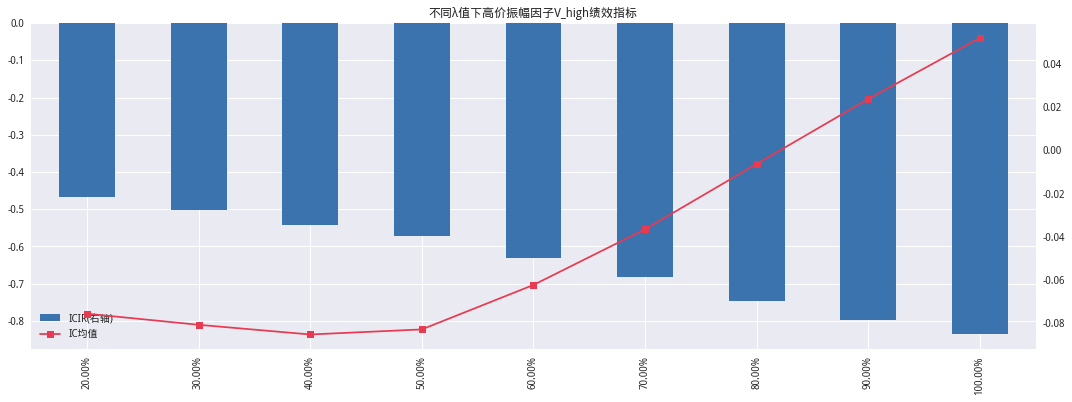

In [15]:
# 画图
mpl.rcParams['font.family'] = 'serif'
fig, v_icir_ax = plt.subplots(figsize=(18, 6))

v_icir_ax.set_title('不同λ值下高价振幅因子V_high绩效指标')
h_icir.plot.bar(ax=v_icir_ax, label='ICIR(右轴)', color='#3A73AD')

icir_ax_tx1 = v_icir_ax.twinx()
v_mean.plot(ax=icir_ax_tx1, label='IC均值',marker='s', color='#E83A51')
plt.grid(False)

h1, l1 = v_icir_ax.get_legend_handles_labels()
h2, l2 = icir_ax_tx1.get_legend_handles_labels()
v_icir_ax.legend(h1+h2, l1+l2);

下图给出了不同λ值下理想振幅因子以及高价振幅因子V_high(20%)的多空对 冲净值表现。从图上我们直观的可以感受到：相较于高价振幅因子，理想振幅因子的 多空对冲收益水平提升，波动水平下降，整体稳定性提升。从不同分组的收益表现来看，不同于高价振幅因子分组收益的非单调，理想振幅因子的分组收益单调排列。整体上，理想振幅因子的选股能力要显著优于高价振幅因子。

In [50]:
# 计算多空收益
v_excess_ret = get_excess_ret(V_factor, list(
    map(lambda x: '%.2f%%' % x, range(20, 100, 10))))

excess_cum = ep.cum_returns(v_excess_ret).add(1)

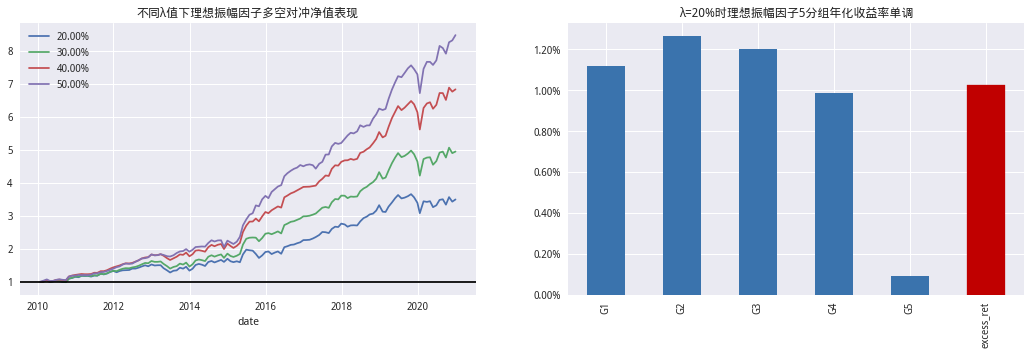

In [51]:
# 画图
mpl.rcParams['font.family'] = 'serif'
fig, excess_plot = plt.subplots(1, 2)

# 画净值
excess_cum[['20.00%', '30.00%', '40.00%', '50.00%']].plot(
    figsize=(18, 5), title='不同λ值下理想振幅因子多空对冲净值表现', ax=excess_plot[0])
excess_plot[0].axhline(1, color='black')

# 画分组平均收益率
lamb_2 = get_algorithm_ret(V_factor, '20.00%')
lamb_2.mean().plot.bar(title='λ=20%时理想振幅因子5分组年化收益率单调',
                       ax=excess_plot[1], color='#3A73AD')

yaxis_format = mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x*100))
excess_plot[1].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(yaxis_format))
bar_ct = excess_plot[1].containers[0]
idx = lamb_2.mean().index.get_loc('excess_ret')
set_color_condition(bar_ct, idx, '#C00000')

In [52]:
# 各组合多空对冲收益情况
risk_indicator_tear(v_excess_ret).T.style.format('{:.2%}')

,20.00%,30.00%,40.00%,50.00%,60.00%,70.00%,80.00%,90.00%
annual_return,12.03%,15.63%,19.08%,21.44%,20.00%,14.63%,8.90%,1.74%
annual_volatility,13.44%,12.65%,11.57%,10.74%,10.41%,11.31%,13.24%,14.67%
max_drawdown,-16.06%,-15.27%,-13.35%,-11.16%,-13.53%,-18.07%,-23.38%,-34.59%


# 理想振幅因子不同样本空间选股表现

In [62]:
# 因子获取
factor_hs300 = prepare_data('000300.XSHG','2010-01-01','2020-12-31','2021-01-31',
             AF_factor,{'func':grid_factor,'params':{'lamb':np.arange(0.2,1.1,0.1),'group':['high','low']}})

factor_zz500 = prepare_data('000905.XSHG','2010-01-01','2020-12-31','2021-01-31',
             AF_factor,{'func':grid_factor,'params':{'lamb':np.arange(0.2,1.1,0.1),'group':['high','low']}})

In [64]:
# 获取V_factor
def get_v_factor(factor_df:pd.DataFrame)->pd.DataFrame:
    
    # 获取高低分组
    high_factor = factor_df.filter(regex='high')
    low_factor = factor_df.filter(regex='low')
    
    # 重命名
    high_factor.columns = [f'%.2f%%' % (float(col[1]) * 100)
                       for col in high_factor.columns.str.split('_')]

    low_factor.columns = [f'%.2f%%' % (float(col[1]) * 100)
                           for col in low_factor.columns.str.split('_')]
    
    v_factor = high_factor - low_factor
    v_factor['next_ret'] = factor_df['next_ret']
    
    return v_factor

最后我们考察理想振幅因子在不同样本空间内的选股能力。由下图可以看到在沪深300中$\lambda=60\%$时收益最好,在中证500中$\lambda=50\%$时收益最好，且在中证500中的表现比沪深300好。

沪深300成分股中（$\lambda=60\%$），因子多空对冲年化收益10.69%，ICIR为-0.269；中证500成分股中（$\lambda=50\%$），因子多空对冲年化收益15.02%，ICIR为-0.425；可以发现，理想振幅因子在中小股票中的选股效果更加优异。

In [68]:
# 获取v_factor
hs300_v = get_v_factor(factor_hs300)
zz500_v = get_v_factor(factor_zz500)

# 计算多空收益
hs300_ret = get_excess_ret(hs300_v, list(
    map(lambda x: '%.2f%%' % x, range(20, 100, 10))))

zz500_ret = get_excess_ret(zz500_v, list(
    map(lambda x: '%.2f%%' % x, range(20, 100, 10))))

hs300_cum = ep.cum_returns(hs300_ret).add(1)
zz500_cum = ep.cum_returns(zz500_ret).add(1)

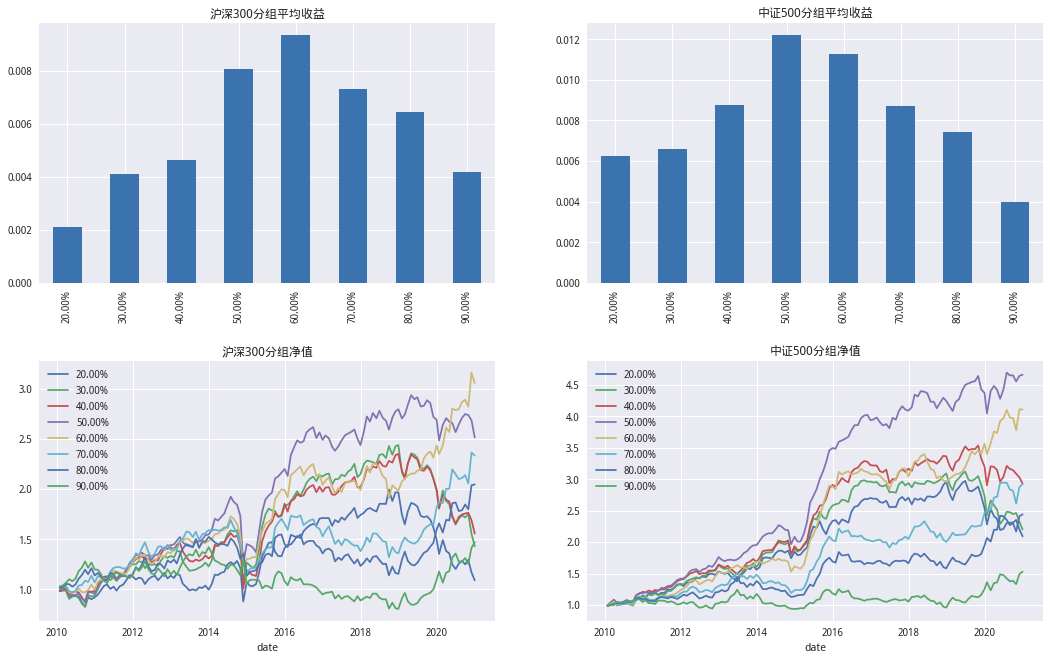

In [81]:
# 画图
fig, v_axes = plt.subplots(2, 2, figsize=(18, 11))

v_axes[0, 0].set_title('沪深300分组平均收益')
hs300_ret.mean().plot.bar(ax=v_axes[0, 0], color='#3A73AD')
v_axes[0, 1].set_title('中证500分组平均收益')
zz500_ret.mean().plot.bar(ax=v_axes[0, 1], color='#3A73AD')
v_axes[1, 0].set_title('沪深300分组净值')
hs300_cum.plot(ax=v_axes[1, 0])
v_axes[1, 1].set_title('中证500分组净值')
zz500_cum.plot(ax=v_axes[1, 1])
plt.subplots_adjust(hspace=0.3);

In [83]:
hs300_ic = hs300_v.groupby(level='date').apply(src_ic)
zz500_ic = zz500_v.groupby(level='date').apply(src_ic)

In [85]:
# 获取IC相关信息
def ic_table(ic_df:pd.DataFrame)->pd.DataFrame:
    
    df = pd.DataFrame()
    df['IC Mean'] = ic_df.mean()
    df['IC Std'] = ic_df.std()
    df['ICIR'] = df['IC Mean'] / df['IC Std']
    
    return df

In [95]:
print_table(ic_table(hs300_ic),name='沪深300 IC信息')
print_table(ic_table(zz500_ic),name='中证500 IC信息')

沪深300 IC信息,IC Mean,IC Std,ICIR
20.00%,-0.048424,0.187261,-0.258594
30.00%,-0.051647,0.172208,-0.299911
40.00%,-0.055378,0.155790,-0.355466
50.00%,-0.053574,0.144403,-0.371000
60.00%,-0.040464,0.150101,-0.269581
70.00%,-0.016503,0.171074,-0.096468
80.00%,0.005077,0.183283,0.027701
90.00%,0.020136,0.201198,0.100079
100.00%,0.032732,0.208437,0.157035


中证500 IC信息,IC Mean,IC Std,ICIR
20.00%,-0.060047,0.139401,-0.430750
30.00%,-0.060320,0.129607,-0.465405
40.00%,-0.062074,0.116176,-0.534308
50.00%,-0.063445,0.106151,-0.597685
60.00%,-0.046837,0.110070,-0.425515
70.00%,-0.025475,0.126010,-0.202170
80.00%,-0.006273,0.140685,-0.044585
90.00%,0.017958,0.153853,0.116720
100.00%,0.040444,0.162734,0.248531


In [98]:
print_table(risk_indicator_tear(hs300_ret), name='沪深300风险指标', fmt='{:.2%}')
print_table(risk_indicator_tear(zz500_ret), name='中证500风险指标', fmt='{:.2%}')

沪深300风险指标,annual_return,annual_volatility,max_drawdown
20.00%,0.78%,18.53%,-45.40%
30.00%,3.30%,18.17%,-41.41%
40.00%,4.10%,17.20%,-35.39%
50.00%,8.74%,15.82%,-35.11%
60.00%,10.69%,14.29%,-28.84%
70.00%,8.01%,14.82%,-30.91%
80.00%,6.72%,15.76%,-26.39%
90.00%,3.55%,17.43%,-43.40%


中证500风险指标,annual_return,annual_volatility,max_drawdown
20.00%,6.93%,12.63%,-29.67%
30.00%,7.43%,12.32%,-29.50%
40.00%,10.27%,11.71%,-17.91%
50.00%,15.02%,10.76%,-13.30%
60.00%,13.71%,11.41%,-12.92%
70.00%,10.24%,11.94%,-20.86%
80.00%,8.45%,12.70%,-21.87%
90.00%,3.94%,13.67%,-24.67%


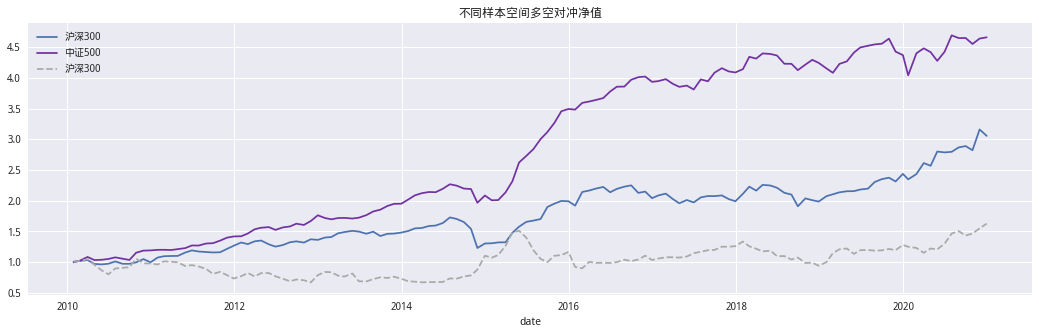

In [110]:
# 画图
mpl.rcParams['font.family'] = 'serif'

beginDt = hs300_cum.index.min()
endDt = hs300_cum.index.max()
benchmark = get_price('000300.XSHG', beginDt, endDt, fields='close')
benchmark = benchmark.reindex(hs300_cum.index)

hs300_cum['60.00%'].plot(figsize=(18, 5), title='不同样本空间多空对冲净值', label='沪深300')
zz500_cum['50.00%'].plot(label='中证500', color='#7232A1')
(benchmark['close'] / benchmark['close'][0]
 ).plot(label='沪深300', color='darkgray', ls='--')
plt.legend();

# 波动类因子的收益来源：一个股价动力学视角


综合所有测算结果，对于波动类因子的收益来源，我们提供一个股价动力学视角的理解框架。以振幅因子为例，我们将振幅加大视为多空博弈强烈的信号， 进而视为该价格状态的不稳定性加大，这意味着该价格状态后续将难以维持，我们将以上过程简称为`“振荡加大-状态跃迁”效应`。振幅因子的收益来源在于：`相比于低价态，高价态下的“振荡加大-状态跃迁”效应更为强烈。这种高低价态的不对称性导致：其一，在振幅因子的切割分析中，高价振幅因子具有更强的负向选股能力， 此即为本文第2节的结论；其二，当不对振幅因子进行切割时，由于高价振幅因子的贡献，振幅因子整体也呈现出负向选股能力，此即为我们最为熟悉的“低波动异象”。`以上，是我们从振幅因子的隐藏结构中，得到的最为重要的启发。